# 超參數調校(Hyperparameter tuning)

## 安裝套件

In [1]:
!pip install ray

## 載入套件

In [2]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from ray import tune
from ray.tune.schedulers import ASHAScheduler

## 判斷是否有GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 建立模型結構

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # In this example, we don't change the model architecture
        # due to simplicity.
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## 定義模型訓練及測試函數

In [40]:
# 訓練週期
EPOCH_SIZE = 5

# 定義模型訓練函數
def train(model, optimizer, train_loader):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

# 定義模型測試函數
def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            # 準確數計算
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

## 定義特徵縮放函數

In [41]:
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ), (0.3081, ))
    ])

## 定義資料載入及模型訓練函數

In [42]:
def train_mnist(config):
    # 載入 MNIST 手寫阿拉伯數字資料
    train_loader = DataLoader(
        datasets.MNIST("", train=True, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)
    test_loader = DataLoader(
        datasets.MNIST("", train=False, transform=mnist_transforms),
        batch_size=64,
        shuffle=True)

    # 建立模型
    model = ConvNet().to(device)

    # 優化器，使用組態參數
    optimizer = optim.SGD(model.parameters(), 
                          lr=config["lr"], momentum=config["momentum"])
    # 訓練 10 週期
    for i in range(10):
        train(model, optimizer, train_loader)
        # 測試
        acc = test(model, test_loader)

        # 訓練結果交回給 Ray Tune
        tune.report(mean_accuracy=acc)

        # 每 5 週期存檔一次
        if i % 5 == 0:
            torch.save(model.state_dict(), "./model.pth")

## 參數調校

In [56]:
# 參數組合
search_space = {
    #"lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "lr": tune.grid_search([0.01, 0.1, 0.5]), # 每一選項都要測試
    "momentum": tune.uniform(0.1, 0.9)        # 均勻分配抽樣
}

# 加下一行，採分散式處理
# ray.init(address="auto")

# 執行參數調校
analysis = tune.run(train_mnist, config=search_space, resources_per_trial={'gpu': 1})

Trial name,status,loc,lr,momentum
train_mnist_632aa_00000,PENDING,,0.01,0.620798
train_mnist_632aa_00001,PENDING,,0.1,0.409923
train_mnist_632aa_00002,PENDING,,0.5,0.651037


 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to MNIST\raw\train-images-idx3-ubyte.gz


 39%|███▉      | 3871744/9912422 [00:01<00:01, 4351303.55it/s]


Trial name,status,loc,lr,momentum
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798
train_mnist_632aa_00001,PENDING,,0.1,0.409923
train_mnist_632aa_00002,PENDING,,0.5,0.651037


 79%|███████▉  | 7811072/9912422 [00:03<00:00, 2469421.28it/s]
9913344it [00:03, 3067231.81it/s]                             


 pid=21828) Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw
 pid=21828) itFunc
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to MNIST\raw\train-labels-idx1-ubyte.gz


29696it [00:00, ?it/s]                   


 pid=21828) Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw
 pid=21828) itFunc
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to MNIST\raw\t10k-images-idx3-ubyte.gz


 77%|███████▋  | 1264640/1648877 [00:01<00:00, 1313844.51it/s]
1649664it [00:01, 1294592.61it/s]                             


 pid=21828) Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw
 pid=21828) itFunc
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
 pid=21828) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to MNIST\raw\t10k-labels-idx1-ubyte.gz


5120it [00:00, ?it/s]                   


 pid=21828) Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
 pid=21828) 


Trial name,status,loc,lr,momentum
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798
train_mnist_632aa_00001,PENDING,,0.1,0.409923
train_mnist_632aa_00002,PENDING,,0.5,0.651037


Trial name,status,loc,lr,momentum
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798
train_mnist_632aa_00001,PENDING,,0.1,0.409923
train_mnist_632aa_00002,PENDING,,0.5,0.651037


Trial name,status,loc,lr,momentum
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798
train_mnist_632aa_00001,PENDING,,0.1,0.409923
train_mnist_632aa_00002,PENDING,,0.5,0.651037


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-11-07
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 1
  mean_accuracy: 0.9142
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 23.59903860092163
  time_this_iter_s: 23.59903860092163
  time_total_s: 23.59903860092163
  timestamp: 1641129067
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9142,1,23.599
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9142,1,23.599
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9142,1,23.599
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-11-21
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 2
  mean_accuracy: 0.945
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 36.71848750114441
  time_this_iter_s: 13.119448900222778
  time_total_s: 36.71848750114441
  timestamp: 1641129081
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.945,2,36.7185
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.945,2,36.7185
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-11-34
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 3
  mean_accuracy: 0.9536
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 49.73205518722534
  time_this_iter_s: 13.013567686080933
  time_total_s: 49.73205518722534
  timestamp: 1641129094
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9536,3,49.7321
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9536,3,49.7321
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9536,3,49.7321
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-11-47
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 4
  mean_accuracy: 0.9564
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 62.833749294281006
  time_this_iter_s: 13.101694107055664
  time_total_s: 62.833749294281006
  timestamp: 1641129107
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9564,4,62.8337
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9564,4,62.8337
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-12-00
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 5
  mean_accuracy: 0.9621
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 75.93815279006958
  time_this_iter_s: 13.104403495788574
  time_total_s: 75.93815279006958
  timestamp: 1641129120
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9621,5,75.9382
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9621,5,75.9382
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9621,5,75.9382
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-12-13
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 6
  mean_accuracy: 0.9618
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 89.21883416175842
  time_this_iter_s: 13.280681371688843
  time_total_s: 89.21883416175842
  timestamp: 1641129133
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9618,6,89.2188
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9618,6,89.2188
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-12-26
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 7
  mean_accuracy: 0.9632
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 102.36614990234375
  time_this_iter_s: 13.147315740585327
  time_total_s: 102.36614990234375
  timestamp: 1641129146
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9632,7,102.366
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9632,7,102.366
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9632,7,102.366
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-12-40
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 8
  mean_accuracy: 0.9631
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 115.63367557525635
  time_this_iter_s: 13.267525672912598
  time_total_s: 115.63367557525635
  timestamp: 1641129160
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9631,8,115.634
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9631,8,115.634
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.9631,8,115.634
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-12-53
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 9
  mean_accuracy: 0.964
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 128.91595602035522
  time_this_iter_s: 13.282280445098877
  time_total_s: 128.91595602035522
  timestamp: 1641129173
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.964,9,128.916
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,RUNNING,127.0.0.1:21828,0.01,0.620798,0.964,9,128.916
train_mnist_632aa_00001,PENDING,,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,


Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-13-06
  done: false
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.9644
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 142.22814011573792
  time_this_iter_s: 13.31218409538269
  time_total_s: 142.22814011573792
  timestamp: 1641129186
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00000
  
Result for train_mnist_632aa_00000:
  date: 2022-01-02_21-13-06
  done: true
  experiment_id: e635b4cc50164158a2385aeed6bf481e
  experiment_tag: 0_lr=0.01,momentum=0.6208
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.9644
  node_ip: 127.0.0.1
  pid: 21828
  time_since_restore: 142.22814011573792
  time_this_iter_s: 13.31218409538269
  time_total_s: 142.22814011573792
  timestamp: 1641129186
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00000
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to MNIST\raw\train-images-idx3-ubyte.gz


 71%|███████   | 7041024/9912422 [00:02<00:00, 3093431.19it/s]
9913344it [00:02, 3964010.69it/s]                             


 pid=22708) Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw
 pid=22708) itFunc
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to MNIST\raw\train-labels-idx1-ubyte.gz


29696it [00:00, 29669855.07it/s]         


 pid=22708) Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw
 pid=22708) itFunc
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to MNIST\raw\t10k-images-idx3-ubyte.gz


  0%|          | 0/1648877 [00:00<?, ?it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


 57%|█████▋    | 943104/1648877 [00:00<00:00, 2356058.34it/s]
1649664it [00:00, 2454174.75it/s]                             


 pid=22708) Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw
 pid=22708) itFunc
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
 pid=22708) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to MNIST\raw\t10k-labels-idx1-ubyte.gz


5120it [00:00, ?it/s]                   


 pid=22708) Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
 pid=22708) 


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,,,
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-13-30
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 1
  mean_accuracy: 0.9527
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 21.51491951942444
  time_this_iter_s: 21.51491951942444
  time_total_s: 21.51491951942444
  timestamp: 1641129210
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9527,1,21.5149
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9527,1,21.5149
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-13-43
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 2
  mean_accuracy: 0.9552
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 34.425164222717285
  time_this_iter_s: 12.910244703292847
  time_total_s: 34.425164222717285
  timestamp: 1641129223
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9552,2,34.4252
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9552,2,34.4252
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9552,2,34.4252
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-13-56
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 3
  mean_accuracy: 0.9541
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 47.27589511871338
  time_this_iter_s: 12.850730895996094
  time_total_s: 47.27589511871338
  timestamp: 1641129236
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9541,3,47.2759
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9541,3,47.2759
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-14-09
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 4
  mean_accuracy: 0.9554
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 60.21736931800842
  time_this_iter_s: 12.941474199295044
  time_total_s: 60.21736931800842
  timestamp: 1641129249
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9554,4,60.2174
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9554,4,60.2174
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-14-22
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 5
  mean_accuracy: 0.9622
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 73.01909828186035
  time_this_iter_s: 12.801728963851929
  time_total_s: 73.01909828186035
  timestamp: 1641129262
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9622,5,73.0191
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9622,5,73.0191
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9622,5,73.0191
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-14-34
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 6
  mean_accuracy: 0.9582
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 85.88369536399841
  time_this_iter_s: 12.864597082138062
  time_total_s: 85.88369536399841
  timestamp: 1641129274
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9582,6,85.8837
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9582,6,85.8837
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-14-47
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 7
  mean_accuracy: 0.9639
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 98.80618381500244
  time_this_iter_s: 12.922488451004028
  time_total_s: 98.80618381500244
  timestamp: 1641129287
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9639,7,98.8062
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9639,7,98.8062
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9639,7,98.8062
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-15-00
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 8
  mean_accuracy: 0.9595
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 111.70902132987976
  time_this_iter_s: 12.90283751487732
  time_total_s: 111.70902132987976
  timestamp: 1641129300
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9595,8,111.709
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9595,8,111.709
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-15-13
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 9
  mean_accuracy: 0.9629
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 124.65132164955139
  time_this_iter_s: 12.94230031967163
  time_total_s: 124.65132164955139
  timestamp: 1641129313
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9629,9,124.651
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00001,RUNNING,127.0.0.1:22708,0.1,0.409923,0.9629,9,124.651
train_mnist_632aa_00002,PENDING,,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228


Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-15-26
  done: false
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.9625
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 137.52846765518188
  time_this_iter_s: 12.877146005630493
  time_total_s: 137.52846765518188
  timestamp: 1641129326
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00001
  
Result for train_mnist_632aa_00001:
  date: 2022-01-02_21-15-26
  done: true
  experiment_id: 6fe5ee93539148baa431cb0473c73e0d
  experiment_tag: 1_lr=0.1,momentum=0.40992
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.9625
  node_ip: 127.0.0.1
  pid: 22708
  time_since_restore: 137.52846765518188
  time_this_iter_s: 12.877146005630493
  time_total_s: 137.52846765518188
  timestamp: 1641129326
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00001
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to MNIST\raw\train-images-idx3-ubyte.gz


  1%|▏         | 131072/9912422 [00:00<00:14, 665692.08it/s]


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


 64%|██████▍   | 6385664/9912422 [00:02<00:01, 2549674.03it/s]
9913344it [00:02, 3485941.52it/s]                             


 pid=21072) Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw
 pid=21072) itFunc
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to MNIST\raw\train-labels-idx1-ubyte.gz


29696it [00:00, 30610482.08it/s]         


 pid=21072) Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw
 pid=21072) itFunc
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to MNIST\raw\t10k-images-idx3-ubyte.gz


 59%|█████▊    | 966656/1648877 [00:00<00:00, 2198591.64it/s]


 pid=21072) Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw
 pid=21072) 
 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz


1649664it [00:00, 2572370.23it/s]                             


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


 pid=21072) Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to MNIST\raw\t10k-labels-idx1-ubyte.gz


5120it [00:00, 4967577.26it/s]          


 pid=21072) Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
 pid=21072) 


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,,,
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-15-55
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 1
  mean_accuracy: 0.0974
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 22.098782539367676
  time_this_iter_s: 22.098782539367676
  time_total_s: 22.098782539367676
  timestamp: 1641129355
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.0974,1,22.0988
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.0974,1,22.0988
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-16-08
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 2
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 35.002235889434814
  time_this_iter_s: 12.903453350067139
  time_total_s: 35.002235889434814
  timestamp: 1641129368
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,2,35.0022
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,2,35.0022
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-16-21
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 3
  mean_accuracy: 0.101
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 47.944971799850464
  time_this_iter_s: 12.94273591041565
  time_total_s: 47.944971799850464
  timestamp: 1641129381
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.101,3,47.945
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.101,3,47.945
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.101,3,47.945
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-16-34
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 4
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 60.84057140350342
  time_this_iter_s: 12.895599603652954
  time_total_s: 60.84057140350342
  timestamp: 1641129394
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,4,60.8406
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,4,60.8406
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-16-47
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 5
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 73.81895446777344
  time_this_iter_s: 12.97838306427002
  time_total_s: 73.81895446777344
  timestamp: 1641129407
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,5,73.819
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,5,73.819
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,5,73.819
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-00
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 6
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 86.8144428730011
  time_this_iter_s: 12.995488405227661
  time_total_s: 86.8144428730011
  timestamp: 1641129420
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,6,86.8144
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,6,86.8144
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-13
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 7
  mean_accuracy: 0.1028
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 99.78912091255188
  time_this_iter_s: 12.974678039550781
  time_total_s: 99.78912091255188
  timestamp: 1641129433
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1028,7,99.7891
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1028,7,99.7891
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-26
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 8
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 112.72352886199951
  time_this_iter_s: 12.934407949447632
  time_total_s: 112.72352886199951
  timestamp: 1641129446
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,8,112.724
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,8,112.724
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,8,112.724
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-39
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 9
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 125.65354490280151
  time_this_iter_s: 12.930016040802002
  time_total_s: 125.65354490280151
  timestamp: 1641129459
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,9,125.654
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00002,RUNNING,127.0.0.1:21072,0.5,0.651037,0.1135,9,125.654
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528


Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-52
  done: false
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 138.6923325061798
  time_this_iter_s: 13.038787603378296
  time_total_s: 138.6923325061798
  timestamp: 1641129472
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00002
  
Result for train_mnist_632aa_00002:
  date: 2022-01-02_21-17-52
  done: true
  experiment_id: 8705d0f4763f47c1be798a6faf64cc65
  experiment_tag: 2_lr=0.5,momentum=0.65104
  hostname: bigpc
  iterations_since_restore: 10
  mean_accuracy: 0.1135
  node_ip: 127.0.0.1
  pid: 21072
  time_since_restore: 138.6923325061798
  time_this_iter_s: 13.038787603378296
  time_total_s: 138.6923325061798
  timestamp: 1641129472
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 632aa_00002
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
train_mnist_632aa_00000,TERMINATED,127.0.0.1:21828,0.01,0.620798,0.9644,10,142.228
train_mnist_632aa_00001,TERMINATED,127.0.0.1:22708,0.1,0.409923,0.9625,10,137.528
train_mnist_632aa_00002,TERMINATED,127.0.0.1:21072,0.5,0.651037,0.1135,10,138.692


2022-01-02 21:17:52,365	INFO tune.py:626 -- Total run time: 430.59 seconds (430.46 seconds for the tuning loop).


## 取得實驗的參數

In [99]:
for i in analysis.get_all_configs().keys():
    print(analysis.get_all_configs()[i])

{'lr': 0.01, 'momentum': 0.6207983646235925}
{'lr': 0.1, 'momentum': 0.409923256970235}
{'lr': 0.5, 'momentum': 0.6510366888598742}


## 對訓練過程的準確率繪圖

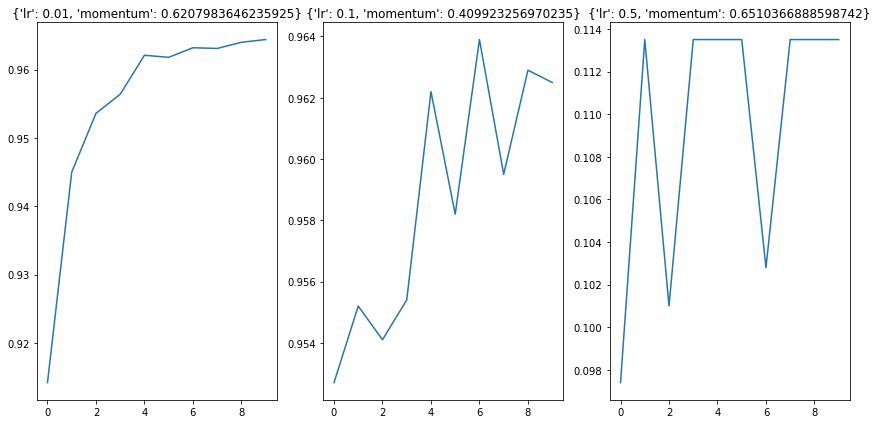

In [107]:
import matplotlib.pyplot as plt 

# 取得實驗的參數
config_list = []
for i in analysis.get_all_configs().keys():
    config_list.append(analysis.get_all_configs()[i])
    
# 繪圖
plt.figure(figsize=(12,6))
dfs = analysis.trial_dataframes
for i, d in enumerate(dfs.values()):
    plt.subplot(1,3,i+1)
    plt.title(config_list[i])
    d.mean_accuracy.plot() 
plt.tight_layout()
plt.show()

## 顯示詳細調校內容

In [88]:
for i in dfs.keys():
    parameters = i.split("\\")[-1]
    print(f'{parameters}\n', dfs[i][['mean_accuracy', 'time_total_s']])

train_mnist_632aa_00000_0_lr=0.01,momentum=0.6208_2022-01-02_21-10-41
    mean_accuracy  time_total_s
0         0.9142     23.599039
1         0.9450     36.718488
2         0.9536     49.732055
3         0.9564     62.833749
4         0.9621     75.938153
5         0.9618     89.218834
6         0.9632    102.366150
7         0.9631    115.633676
8         0.9640    128.915956
9         0.9644    142.228140
train_mnist_632aa_00001_1_lr=0.1,momentum=0.40992_2022-01-02_21-10-42
    mean_accuracy  time_total_s
0         0.9527     21.514920
1         0.9552     34.425164
2         0.9541     47.275895
3         0.9554     60.217369
4         0.9622     73.019098
5         0.9582     85.883695
6         0.9639     98.806184
7         0.9595    111.709021
8         0.9629    124.651322
9         0.9625    137.528468
train_mnist_632aa_00002_2_lr=0.5,momentum=0.65104_2022-01-02_21-13-06
    mean_accuracy  time_total_s
0         0.0974     22.098783
1         0.1135     35.002236
2         0.

In [109]:
analysis.results_df

,mean_accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.lr,config.momentum
trial_id,,,,,,,,,,,,,,,,,,,
632aa_00000,0.9644,13.312184,True,None,None,10,e635b4cc50164158a2385aeed6bf481e,2022-01-02_21-13-06,1641129186,142.228140,21828,bigpc,127.0.0.1,142.228140,0,10,"0_lr=0.01,momentum=0.6208",0.01,0.620798
632aa_00001,0.9625,12.877146,True,None,None,10,6fe5ee93539148baa431cb0473c73e0d,2022-01-02_21-15-26,1641129326,137.528468,22708,bigpc,127.0.0.1,137.528468,0,10,"1_lr=0.1,momentum=0.40992",0.10,0.409923
632aa_00002,0.1135,13.038788,True,None,None,10,8705d0f4763f47c1be798a6faf64cc65,2022-01-02_21-17-52,1641129472,138.692333,21072,bigpc,127.0.0.1,138.692333,0,10,"2_lr=0.5,momentum=0.65104",0.50,0.651037


## 取得最佳模型參數

In [79]:
best_trial = analysis.get_best_trial("mean_accuracy", "max", "last")
best_trial.config

{'lr': 0.01, 'momentum': 0.6207983646235925}

## 載入最佳模型

In [75]:
logdir = analysis.get_best_logdir("mean_accuracy", mode="max")
state_dict = torch.load(os.path.join(logdir, "model.pth"))

model = ConvNet().to(device)
model.load_state_dict(state_dict)

<All keys matched successfully>

## 測試資料評分(Score Model)

In [50]:
test_ds = datasets.MNIST('', train=False, download=True, transform=mnist_transforms)

# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=1000)

model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # 正確筆數
        _, predicted = torch.max(output, 1)
        correct += (predicted == target).sum().item()

# 顯示測試結果
data_count = len(test_loader.dataset)
percentage = 100.0 * correct / data_count
print(f'準確率: {correct}/{data_count} ({percentage:.0f}%)\n')

準確率: 9722/10000 (97%)

